# 4.6 Auto-encoders

Autoencoders are neural networks that learn to efficiently compress and encode data then learn to reconstruct the data back from the reduced encoded representation to a representation that is as close to the original input as possible. Therefore, autoencoders reduce the dimensionality of the input data i.e. reducing the number of features that describe input data.

They are popular for data denoising, data compression, feature extraction, image reconstruction and segmentation.

![Auto-encoder](../img/autoen_architecture.png)
<!-- <center><img src="figures/autoen_architecture.png" alt="cnn" style="width: 800px;"/></center> -->
The architecture of auto-encoders are typically symmetrical: 
* the encoder: branch of the network that encodes the data (feature extraction). The branch may contain blocks of neural networks such as linear layers, convolutional layers, 
* the bottleneck: smallest layer of the network that contains the smallest number of features, the lowest dimension of the data representation.
* The decoder: branch of the network that takes the features and reconstruct the original data.



Find interesting overview of several canonical architectures of auto-encoders:
https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import sklearn
from sklearn.model_selection import train_test_split
from torchinfo import summary
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import load_digits,fetch_openml
from sklearn.preprocessing import StandardScaler
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import transforms, ToTensor, Compose,Normalize
from sklearn.model_selection import train_test_split
from torchvision import datasets
import torch
import torch.nn as nn
import numpy as np
import os


# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
dataset = datasets.FashionMNIST(root="./",download=True, transform=Compose([ToTensor(),Normalize([0.5],[0.5])]))


100%|██████████| 26421880/26421880 [00:02<00:00, 10417165.17it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 175578.14it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3538808.13it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8317518.10it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [22]:
L = len(dataset)
print(L)

60000


In [23]:
# Training set 80% and Validation set 20%
Lt = int(0.8*L)

train_data, val_data = torch.utils.data.random_split(dataset, [Lt,L-Lt])

In [25]:
loaded_train = DataLoader(train_data, batch_size=50,shuffle=True)
loaded_test = DataLoader(val_data, batch_size=50,shuffle=True)


X, y = next(iter(loaded_train))
print(X.shape)

torch.Size([50, 1, 28, 28])


In [24]:
y

tensor([8, 1, 1, 1, 7, 5, 9, 9, 4, 9, 6, 2, 9, 0, 2, 3, 0, 6, 1, 9, 7, 4, 7, 1,
        1, 0, 4, 3, 0, 1, 5, 5, 4, 8, 4, 6, 9, 1, 5, 1, 9, 6, 9, 7, 9, 5, 1, 7,
        5, 2])

Here is the example of an auto-encoder that only has fully connected layers.

In [26]:
class StackedEncoder(nn.Module):
    def __init__(self):
        super(StackedEncoder, self).__init__() # inherit from parent class
        self.flatten = nn.Flatten() # flatten the input
        self.fc1 = nn.Linear(28*28, 100) # 28*28 input features, 100 output features
        self.fc2 = nn.Linear(100, 30) # 100 input features, 30 output features
        self.activation = nn.SELU() # activation function

    def forward(self, x):
        x = self.flatten(x)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x)) # bottleneck layer
        return x


class StackedDecoder(nn.Module):
    def __init__(self): 
        super(StackedDecoder, self).__init__() # inherit from parent class
        self.fc1 = nn.Linear(30, 100) # 30 input features, 100 output features
        self.fc2 = nn.Linear(100, 28*28) # 100 input features, 28*28 output features
        self.activation = nn.SELU() # activation function
        self.sigmoid = nn.Sigmoid() # sigmoid function

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

class StackedAE(nn.Module): # general  stacked autoencoder
    def __init__(self, encoder, decoder):
        super(StackedAE, self).__init__() # inherit from parent class
        self.encoder = encoder # encoder: it could be any encoder branch
        self.decoder = decoder # decoder: it could be any decoder branc

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x).view(-1, 1, 28, 28) # reshape the output
        return x

# Instantiate the models
stacked_encoder = StackedEncoder()
stacked_decoder = StackedDecoder()
stacked_ae = StackedAE(stacked_encoder, stacked_decoder).to(device) # send the model to GPU

# Print model summary
summary(stacked_ae, input_size=(1000, 28, 28))


Layer (type:depth-idx)                   Output Shape              Param #
StackedAE                                [1000, 1, 28, 28]         --
├─StackedEncoder: 1-1                    [1000, 30]                --
│    └─Flatten: 2-1                      [1000, 784]               --
│    └─Linear: 2-2                       [1000, 100]               78,500
│    └─SELU: 2-3                         [1000, 100]               --
│    └─Linear: 2-4                       [1000, 30]                3,030
│    └─SELU: 2-5                         [1000, 30]                --
├─StackedDecoder: 1-2                    [1000, 784]               --
│    └─Linear: 2-6                       [1000, 100]               3,100
│    └─SELU: 2-7                         [1000, 100]               --
│    └─Linear: 2-8                       [1000, 784]               79,184
│    └─Sigmoid: 2-9                      [1000, 784]               --
Total params: 163,814
Trainable params: 163,814
Non-trainable params: 0

Function to train the model

In [27]:
def train(model, n_epochs, trainloader, testloader=None,learning_rate=0.001 ):

    # Create directory for saving model
    dir1 = './stacked_ae_checkpoint'
    os.makedirs(dir1,exist_ok=True)
    # Define loss and optimization method
    criterion = nn.MSELoss() 
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # # Save loss and error for plotting
    loss_time = np.zeros(n_epochs)
    loss_val_time = np.zeros(n_epochs)

    # # Loop on number of epochs
    for epoch in range(n_epochs):
        # Initialize the loss
        running_loss = 0
        # Loop on samples in train set
        for data in trainloader:
            # Get the sample and modify the format for PyTorch
            inputs= data[0].to(device) # send data to GPU
            inputs = inputs.float()
            # Set the parameter gradients to zero
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs) # the loss is the difference between the input and the reconstructed input
            # Propagate the loss backward
            loss.backward()
            # Update the gradients
            optimizer.step()
            # Add the value of the loss for this sample
            running_loss += loss.item()
        # Save loss at the end of each epoch
        loss_time[epoch] = running_loss/len(trainloader)

        

        checkpoint = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
                        }
        
        f_path = dir1+'/checkpoint.pt'
        torch.save(checkpoint, f_path)
        

        
        # After each epoch, evaluate the performance on the test set
        if testloader is not None:

            running_val_loss = 0
            # We evaluate the model, so we do not need the gradient
            with torch.no_grad(): # Context-manager that disabled gradient calculation.
                # Loop on samples in test set
                for data in testloader:
                    # Get the sample and modify the format for PyTorch
                    inputs = data[0].to(device) # send data to GPU  
                    inputs = inputs.float() 
                    # Use model for sample in the test set
                    outputs = model(inputs)
                    # Compare predicted label and true label
                    loss = criterion(outputs, inputs) # the loss is the difference between the input and the reconstructed input
                    # _, predicted = torch.max(outputs.data, 1)
                    
                    running_val_loss += loss.item()
        
        loss_val_time[epoch] = running_val_loss/len(testloader)
        # Print intermediate results on screen
        if testloader is not None:
            print('[Epoch %d] train loss: %.3f - val loss: %.3f' %
              (epoch + 1, running_loss/len(trainloader), running_val_loss/len(testloader)))
        else:
            print('[Epoch %d] loss: %.3f' %
              (epoch + 1, running_loss/len(trainloader)))

    # Save history of loss and test error
    if testloader is not None:
        return (loss_time, loss_val_time)
    else:
        return (loss_time)
        

In [28]:
stackae = StackedAE(stacked_encoder, stacked_decoder).to(device)

The loss function in this case is not a MSE but instead a multilabel binary classifier on the probability of the pixel. 

In [29]:
(loss, loss_val) = train(stacked_ae, 15,loaded_train, loaded_test,learning_rate=0.005)

[Epoch 1] train loss: 0.616 - val loss: 0.602
[Epoch 2] train loss: 0.598 - val loss: 0.597
[Epoch 3] train loss: 0.596 - val loss: 0.596
[Epoch 4] train loss: 0.595 - val loss: 0.595
[Epoch 5] train loss: 0.594 - val loss: 0.595
[Epoch 6] train loss: 0.594 - val loss: 0.595
[Epoch 7] train loss: 0.594 - val loss: 0.594
[Epoch 8] train loss: 0.594 - val loss: 0.594
[Epoch 9] train loss: 0.593 - val loss: 0.594
[Epoch 10] train loss: 0.593 - val loss: 0.594
[Epoch 11] train loss: 0.593 - val loss: 0.594
[Epoch 12] train loss: 0.593 - val loss: 0.594
[Epoch 13] train loss: 0.593 - val loss: 0.593
[Epoch 14] train loss: 0.593 - val loss: 0.594
[Epoch 15] train loss: 0.593 - val loss: 0.593


Plot the loss curve

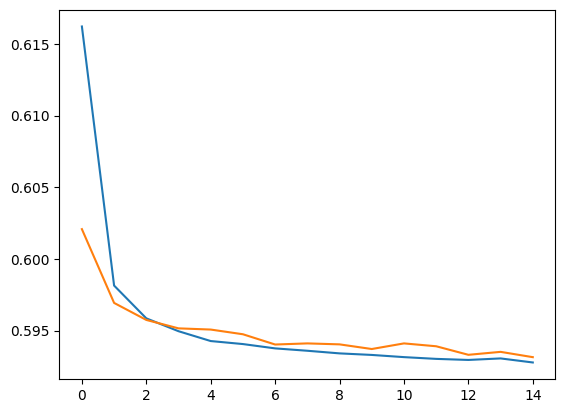

In [30]:
plt.plot(loss  , label='Training loss')
plt.plot(loss_val  , label='Validation loss')

We can visualize the reconstruction images.

In [50]:
def plot_image(image):
    plt.imshow(image,cmap="binary")
    plt.axis("off")
    
def show_reconstruction(model,n_images=5):
    reconstruction=model(X[:n_images])
    for image_index in range(n_images):
        plt.subplot(2,n_images,1+image_index)
        crap=X[image_index].detach().numpy().squeeze()
        plot_image(crap)
        plt.subplot(2,n_images,1+n_images+image_index)
        crap2=reconstruction[image_index].detach().numpy().squeeze()
        plot_image(crap2)

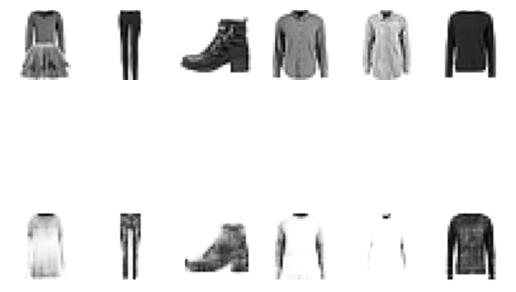

In [51]:
show_reconstruction(stacked_ae,n_images=6)

This is not bad, but not great either. One could imagine training for longer or changing the architecture to include more layers or convolutional layers.


# Convolutional autoencoder

Auto-encoders that have convolutional layers


In [38]:

# Define the CNN autoencoder model in PyTorch
class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [39]:
stacked_cnnae = CNNAutoencoder().to(device) # send the model to GPU

# Print model summary
summary(stacked_cnnae, input_size=( 1,28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNNAutoencoder                           [1, 28, 28]               --
├─Sequential: 1-1                        [32, 7, 7]                --
│    └─Conv2d: 2-1                       [16, 14, 14]              160
│    └─ReLU: 2-2                         [16, 14, 14]              --
│    └─Conv2d: 2-3                       [32, 7, 7]                4,640
│    └─ReLU: 2-4                         [32, 7, 7]                --
├─Sequential: 1-2                        [1, 28, 28]               --
│    └─ConvTranspose2d: 2-5              [16, 14, 14]              4,624
│    └─ReLU: 2-6                         [16, 14, 14]              --
│    └─ConvTranspose2d: 2-7              [1, 28, 28]               145
│    └─Sigmoid: 2-8                      [1, 28, 28]               --
Total params: 9,569
Trainable params: 9,569
Non-trainable params: 0
Total mult-adds (M): 2.12
Input size (MB): 0.00
Forward/backward pass size (MB)

In [40]:
(loss, loss_val) = train(stacked_cnnae, 10,loaded_train, loaded_test)

[Epoch 1] train loss: 0.611 - val loss: 0.577
[Epoch 2] train loss: 0.574 - val loss: 0.573
[Epoch 3] train loss: 0.572 - val loss: 0.572
[Epoch 4] train loss: 0.571 - val loss: 0.571
[Epoch 5] train loss: 0.571 - val loss: 0.571
[Epoch 6] train loss: 0.570 - val loss: 0.571
[Epoch 7] train loss: 0.570 - val loss: 0.571
[Epoch 8] train loss: 0.570 - val loss: 0.571
[Epoch 9] train loss: 0.570 - val loss: 0.570
[Epoch 10] train loss: 0.570 - val loss: 0.570


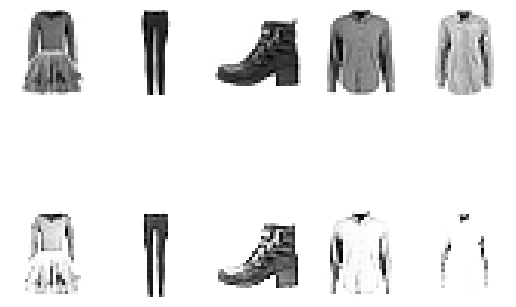

In [52]:
show_reconstruction(stacked_cnnae)

#  Denoising auto-encoder

Instead of training on the same input and output data, we can train a noisy data to represent a clean data.

![Denoiser](../img/denoising-autoencoder-architecture.png)
<!-- <center><img src="figures/denoising-autoencoder-architecture.png" alt="cnn" style="width: 800px;"/></center> -->

When starting with noise-free data, there are two ways to implement a denoising algorithm. First, one add noise to the data. Keras has a built in layer called GaussianNoise, but it would be easily implemented by adding a more structured noise to the data (use domain-knowledge). Second, one can use DropOut layer.

In [56]:

# Define the CNN autoencoder model in PyTorch
class DenoiseCNNAE(nn.Module):
    def __init__(self):
        super(DenoiseCNNAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Dropout(0.4), #  Dropout layer to mimic noisy data
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [57]:
# Instantiate the model
model_denoised_CNNAE = DenoiseCNNAE()

In [58]:
(loss, loss_val) = train(model_denoised_CNNAE, 10,loaded_train, loaded_test)

[Epoch 1] train loss: 0.615 - val loss: 0.588
[Epoch 2] train loss: 0.586 - val loss: 0.586
[Epoch 3] train loss: 0.585 - val loss: 0.585
[Epoch 4] train loss: 0.584 - val loss: 0.584
[Epoch 5] train loss: 0.583 - val loss: 0.583
[Epoch 6] train loss: 0.582 - val loss: 0.582
[Epoch 7] train loss: 0.582 - val loss: 0.582
[Epoch 8] train loss: 0.581 - val loss: 0.582
[Epoch 9] train loss: 0.581 - val loss: 0.581
[Epoch 10] train loss: 0.580 - val loss: 0.581


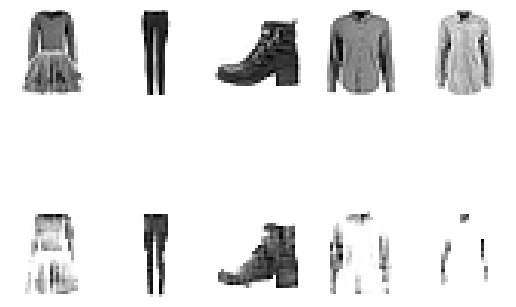

In [59]:
show_reconstruction(model_denoised_CNNAE)

# U-Net

These examples illustrates one of the limitations of auto-encoders. They cannot reconstruct high-fidelity data. The reconstructed image is **low resolution** because indeed, we reconstruct from a low-dimension feature space.

A strategy to recover high-resolution feature is to introduce ***skip connections***: feed the output of the initial layers from the encoder branch as inputs to the layers of the decoder branch. This concept was also introduced in the *ResNet*, which is a deep sequential neural network with added skip (residual) connections. A **residual block** is one that takes the output of a layer, and sum with the output of an earlier layer.

**U-nets** are encoder-decoders with skip connections introduced in the biomedical field.

![Unet](../img/Unet.png)



# Examples in seismology 

The DeepDenoiser is a [Zhu et al., 2019](https://ieeexplore.ieee.org/abstract/document/8802278) is an interesting architecture to remove noise from seismograms
![DeepDenoiser](../img/DeepDenoiser_architecture.png)
<!-- <center><img src="figures/DeepDenoiser_architecture.png" alt="cnn" style="width: 800px;"/></center> -->
<center>Architecture of the DeepDenoiser Zhu et al, 2019: </center>
The input is 2 images of the real and imaginary part of the short time Fourier transform of a seismogram. The outputs are 2 masks to apply on the data to extract the noise and the clean signal time series.

You will note that the auto-encoder has skip connections. These have shown to improve training convergence and performance. They break the sequence of the neural networks, therefore we need to introduce wide neural networks! Stay tuned as I update this tutorial.

Example of denoising seismogram is shown below.

![DeepDenoiser](../img/DeepDenoiser_example.png)
<!-- <center><img src="figures/DeepDenoiser_example.png" alt="cnn" style="width: 800px;"/></center> -->
Example of the DeepDenoiser Zhu et al, 2019

# Encoder-Decoders: Multi-task models

From the bottleneck, it is possible to decode several data types. In seismology, there are several models that propose a multi-task algorithm. 


One of such examples is that of the "Earthquake Transformer" from [Mousavi et al., 2020](https://www.nature.com/articles/s41467-020-17591-w) that takes on 3-component seismograms and predicts 3 probabilities: that of the presence of waveforms (detection branch), the probability of a P wave, the probability of an S wave.

![Earthquake Transformer](../img/EqT.png)

From [Mousavi et al., 2020](https://www.nature.com/articles/s41467-020-17591-w)


Another example is that of [Yin et al., 2022](https://academic.oup.com/gji/article/231/3/1806/6651381), the "WaveDecompNet" that separate Earthquake signals from Noise signals. The noise signals may contain interesting, rather stationary or diffuse wavefield properties that can be used for seismological research. The idea of the model is to **decompose** the signals to output **2** useful time series from a noisy waveform.


![WaveDecompNet](../img/wavedecompnet.jpeg)

From [Yin et al., 2022](https://academic.oup.com/gji/article/231/3/1806/6651381), the WaveDecompNet has two bottlenecks to extract the low dimensionality of earthquake (transient) signals and of noise (diffuse, stationary) signals.


## Latent Space: the low dimensionality of the data
The number of features in the bottleneck is a lower dimension representation of the input data. It is common practice to attempt to visualize the features at this stage. Visualization may require further dimensionality reduction such as PCA.

TO KEEP EDITING

In [ ]:
from sklearn.manifold import TSNE
X_val_compressed = stacked_encoder.predict(X_val)
tsne=TSNE()
X_val_2d=tsne.fit_transform(X_val_compressed)
plt.scatter(X_val_2d[:,0],X_val_2d[:,1],c=y_val,s=10,cmap="tab10")